# Basket Spread Analysis: 1.5*Picnic Basket 2 + DJEMBE vs Picnic Basket 1

This notebook analyzes the spread between 1.5*PICNIC_BASKET2 + DJEMBE and PICNIC_BASKET1 to identify potential arbitrage opportunities.

In [16]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

# Add data_utils to path
sys.path.append(os.path.abspath('../data_utils'))
try:
    import util_minimal
    print("Successfully imported util_minimal")
except ImportError:
    print("Could not import util_minimal")

# Try to import backtester package
try:
    sys.path.append(os.path.abspath('../../'))
    from backtester import get_price_data
    print("Successfully imported backtester.get_price_data")
except ImportError:
    print("Could not import backtester")

Successfully imported util_minimal
Successfully imported backtester.get_price_data


## 1. Load Data

First, let's load the price data for Round 2, focusing on PICNIC_BASKET1, PICNIC_BASKET2, and DJEMBE.

In [17]:
# Define products we need
products = ['PICNIC_BASKET1', 'PICNIC_BASKET2', 'DJEMBES']
product_data = {product: pd.DataFrame() for product in products}

# Try to load data using backtester package
has_data = False
try:
    for product in products:
        print(f"Loading {product} data using backtester...")
        product_data[product] = get_price_data(product, 2)
        print(f"Loaded {len(product_data[product])} rows of {product} data")
    has_data = all(len(data) > 0 for data in product_data.values())
    if has_data:
        print("Successfully loaded all required data using backtester")
except Exception as e:
    print(f"Error loading data using backtester: {e}")
    has_data = False

# If backtester package didn't work, try using util module
if not has_data:
    print("Trying to load data using util module...")
    try:
        reload(util_minimal)
        dm2p = util_minimal.load_all_price_data(2)
        print(f"Loaded {len(dm2p)} rows of data")
        
        # Display the first few rows
        print("\nFirst few rows of data:")
        display(dm2p.head())
        
        # Filter for each product
        for product in products:
            if product in dm2p['product'].unique():
                product_data[product] = dm2p[dm2p['product'] == product].copy()
                print(f"Filtered {len(product_data[product])} rows of {product} data")
            else:
                print(f"No {product} data found")
                product_data[product] = pd.DataFrame()
        
        has_data = all(len(data) > 0 for data in product_data.values())
        if has_data:
            print("Successfully loaded all required data using util module")
    except Exception as e:
        print(f"Error loading data using util module: {e}")
        has_data = False

Loading PICNIC_BASKET1 data using backtester...
Loading real data for PICNIC_BASKET1 from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of PICNIC_BASKET1 data
Loading PICNIC_BASKET2 data using backtester...
Loading real data for PICNIC_BASKET2 from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of PICNIC_BASKET2 data
Loading DJEMBES data using backtester...
Loading real da

## 2. Check Data Availability

Let's check if we have all the necessary data for our analysis.

In [18]:
# Check if we have all the necessary data
missing_products = [product for product in products if len(product_data[product]) == 0]

if missing_products:
    print(f"Missing data for the following products: {', '.join(missing_products)}")
    print("Cannot perform basket spread analysis without all required products.")
else:
    print("All required products are available for basket spread analysis.")
    
    # Display basic information about each product
    for product in products:
        data = product_data[product]
        print(f"\n{product} data:")
        print(f"Number of rows: {len(data)}")
        print(f"Columns: {', '.join(data.columns)}")

All required products are available for basket spread analysis.

PICNIC_BASKET1 data:
Number of rows: 30000
Columns: day, product, bid_price_1, bid_volume_1, bid_price_2, bid_volume_2, bid_price_3, bid_volume_3, ask_price_1, ask_volume_1, ask_price_2, ask_volume_2, ask_price_3, ask_volume_3, mid_price, profit_and_loss, vwap

PICNIC_BASKET2 data:
Number of rows: 30000
Columns: day, product, bid_price_1, bid_volume_1, bid_price_2, bid_volume_2, bid_price_3, bid_volume_3, ask_price_1, ask_volume_1, ask_price_2, ask_volume_2, ask_price_3, ask_volume_3, mid_price, profit_and_loss, vwap

DJEMBES data:
Number of rows: 30000
Columns: day, product, bid_price_1, bid_volume_1, bid_price_2, bid_volume_2, bid_price_3, bid_volume_3, ask_price_1, ask_volume_1, ask_price_2, ask_volume_2, ask_price_3, ask_volume_3, mid_price, profit_and_loss, vwap


## 3. Calculate VWAP

Now let's calculate Volume-Weighted Average Price (VWAP) for each product, which we'll use for our spread analysis.


Input data check:
--------------------------------------------------

PICNIC_BASKET1:
Number of rows: 30000
Columns: ['day', 'product', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss', 'vwap']
First few rows of price data:
           bid_price_1  bid_price_2  bid_price_3  ask_price_1  ask_price_2  \
timestamp                                                                    
0                59284      59283.0          NaN        59294      59295.0   
100              59282      59281.0          NaN        59292      59293.0   
200              59288      59287.0          NaN        59299      59300.0   
300              59289      59288.0      59287.0        59298      59299.0   
400              59290      59289.0      59288.0        59294      59299.0   

           ask_price_3  mid_price  
timestamp               

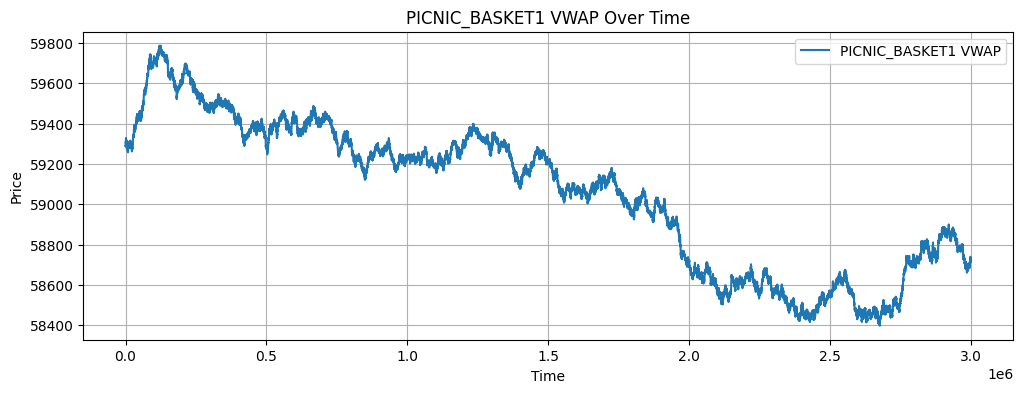


PICNIC_BASKET2 VWAP summary:
Number of points: 30000
Range: 29987.50 to 30813.00
Sample of values:
timestamp
0      30609.0
100    30613.0
200    30615.0
300    30620.5
400    30621.0
dtype: float64


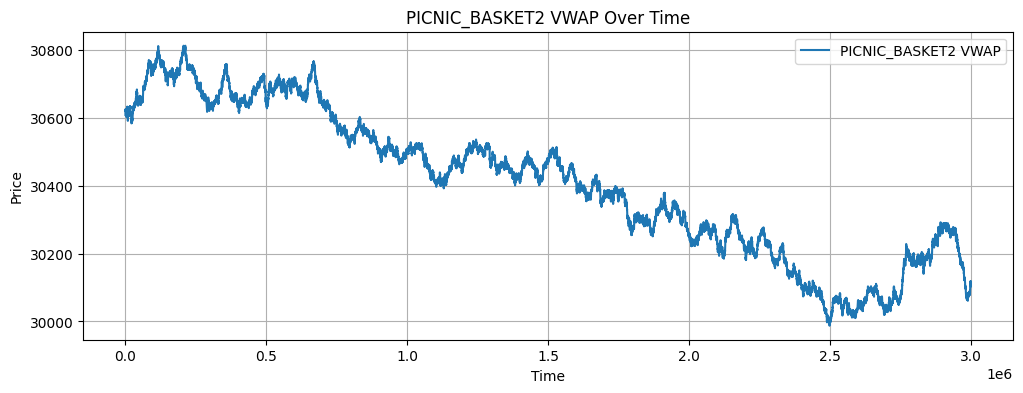


DJEMBES VWAP summary:
Number of points: 30000
Range: 13353.00 to 13519.50
Sample of values:
timestamp
0      13450.5
100    13450.0
200    13450.5
300    13450.0
400    13452.5
dtype: float64


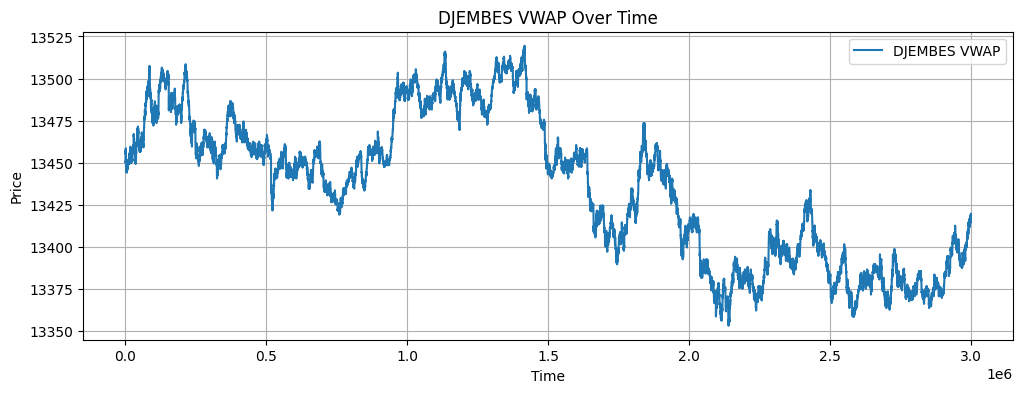

In [21]:
def calculate_vwap(product_data):
    vwap_prices = {}
    for product, data in product_data.items():
        if len(data) > 0:
            try:
                # Calculate VWAP directly
                df = data.copy()
                
                # Calculate mid price
                if 'mid_price' not in df.columns:
                    df['mid_price'] = (df['ask_price_1'] + df['bid_price_1']) / 2
                
                # Calculate total volume at each level
                volume_cols = [
                    'ask_volume_1', 'ask_volume_2', 'ask_volume_3',
                    'bid_volume_1', 'bid_volume_2', 'bid_volume_3'
                ]
                
                # Ensure all volume columns exist, fill missing with 0
                for col in volume_cols:
                    if col not in df.columns:
                        print(f"Warning: {col} not found for {product}, using 0")
                        df[col] = 0
                
                # Calculate total volume and price * volume
                df['total_volume'] = df[volume_cols].sum(axis=1)
                df['price_volume'] = df['mid_price'] * df['total_volume']
                
                # Group by timestamp if available, otherwise use index
                if 'timestamp' in df.columns:
                    grouped = df.groupby('timestamp')
                else:
                    grouped = df.groupby(df.index)
                
                # Calculate VWAP
                vwap = grouped['price_volume'].sum() / grouped['total_volume'].sum()
                
                # Basic validation
                if vwap.isna().all():
                    raise ValueError("VWAP calculation resulted in all NaN values")
                
                vwap_prices[product] = vwap
                print(f"\nVWAP calculation successful for {product}:")
                print(f"- Number of price points: {len(vwap)}")
                print(f"- VWAP range: {vwap.min():.2f} to {vwap.max():.2f}")
                print(f"- NaN values: {vwap.isna().sum()}")
                
            except Exception as e:
                print(f"\nError calculating VWAP for {product}: {e}")
                print("Available columns:", data.columns.tolist())
                print(f"Number of rows: {len(data)}")
                
                # Try fallback to mid price
                try:
                    if 'mid_price' in data.columns:
                        vwap_prices[product] = data['mid_price']
                        print(f"Falling back to mid price for {product}")
                    elif 'ask_price_1' in data.columns and 'bid_price_1' in data.columns:
                        mid_price = (data['ask_price_1'] + data['bid_price_1']) / 2
                        vwap_prices[product] = mid_price
                        print(f"Falling back to calculated mid price for {product}")
                    else:
                        print(f"Cannot calculate VWAP or mid price for {product}")
                except Exception as e:
                    print(f"Fallback also failed for {product}: {e}")
    
    return vwap_prices

# Calculate VWAP for all products
if has_data:
    try:
        # First, let's check the input data
        print("\nInput data check:")
        print("-" * 50)
        for product, data in product_data.items():
            print(f"\n{product}:")
            print(f"Number of rows: {len(data)}")
            print("Columns:", data.columns.tolist())
            print("First few rows of price data:")
            if len(data) > 0:
                price_cols = [col for col in data.columns if 'price' in col]
                print(data[price_cols].head())
        
        # Calculate VWAP
        vwap_prices = calculate_vwap(product_data)
        
        # Verify results
        print("\nVWAP calculation results:")
        print("-" * 50)
        for product, prices in vwap_prices.items():
            print(f"\n{product} VWAP summary:")
            print(f"Number of points: {len(prices)}")
            print(f"Range: {prices.min():.2f} to {prices.max():.2f}")
            print(f"Sample of values:")
            print(prices.head())
            
            # Plot VWAP for visual verification
            plt.figure(figsize=(12, 4))
            plt.plot(prices, label=f'{product} VWAP')
            plt.title(f'{product} VWAP Over Time')
            plt.xlabel('Time')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.show()
            
    except Exception as e:
        print(f"Error in VWAP calculation process: {e}")
else:
    print("Cannot calculate VWAP due to missing data")

## 4. Calculate the Spread

Now we'll calculate the spread between 1.5*PICNIC_BASKET2 + DJEMBE and PICNIC_BASKET1 using VWAP prices.

In [22]:
# Function to calculate the spread
def calculate_spread(price_data):
    # Create a common index for all products
    all_indices = set()
    for product, prices in price_data.items():
        all_indices.update(prices.index)
    common_index = sorted(all_indices)
    
    # Reindex all price series to the common index and forward fill missing values
    reindexed_prices = {}
    for product, prices in price_data.items():
        reindexed_prices[product] = prices.reindex(common_index).ffill().bfill()
    
    # Calculate the spread: 1.5*PICNIC_BASKET2 + DJEMBE - PICNIC_BASKET1
    if all(p in reindexed_prices for p in ['PICNIC_BASKET1', 'PICNIC_BASKET2', 'DJEMBES']):
        # Calculate the artificial basket (1.5*PICNIC_BASKET2 + DJEMBE)
        artificial_basket = (
            1.5 * reindexed_prices['PICNIC_BASKET2'] + 
            reindexed_prices['DJEMBES']
        )
        
        # Calculate the spread (artificial_basket - PICNIC_BASKET1)
        spread = artificial_basket - reindexed_prices['PICNIC_BASKET1']
        
        return spread, reindexed_prices, artificial_basket
    else:
        missing = [p for p in ['PICNIC_BASKET1', 'PICNIC_BASKET2', 'DJEMBES'] if p not in reindexed_prices]
        print(f"Cannot calculate spread. Missing prices for: {', '.join(missing)}")
        return None, reindexed_prices, None

# Calculate the spread
if has_data and 'vwap_prices' in locals():
    try:
        spread, reindexed_prices, artificial_basket = calculate_spread(vwap_prices)
        if spread is not None:
            print("Successfully calculated the spread")
            
            # Display basic statistics about the spread
            print("\nSpread statistics:")
            print(f"Mean: {spread.mean():.2f}")
            print(f"Median: {spread.median():.2f}")
            print(f"Min: {spread.min():.2f}")
            print(f"Max: {spread.max():.2f}")
            print(f"Standard deviation: {spread.std():.2f}")
            
            # Display the first few values of the spread
            print("\nSpread (first 5 values):")
            display(spread.head())
    except Exception as e:
        print(f"Error calculating spread: {e}")
else:
    print("Cannot calculate spread due to missing VWAP data")

Successfully calculated the spread

Spread statistics:
Mean: -3.41
Median: -13.25
Min: -204.00
Max: 267.50
Standard deviation: 93.51

Spread (first 5 values):


timestamp
0      75.00
100    82.50
200    79.50
300    87.25
400    92.00
dtype: float64

## 5. Visualize the Baskets and Spread

Let's visualize the baskets and spread over time to better understand their behavior.

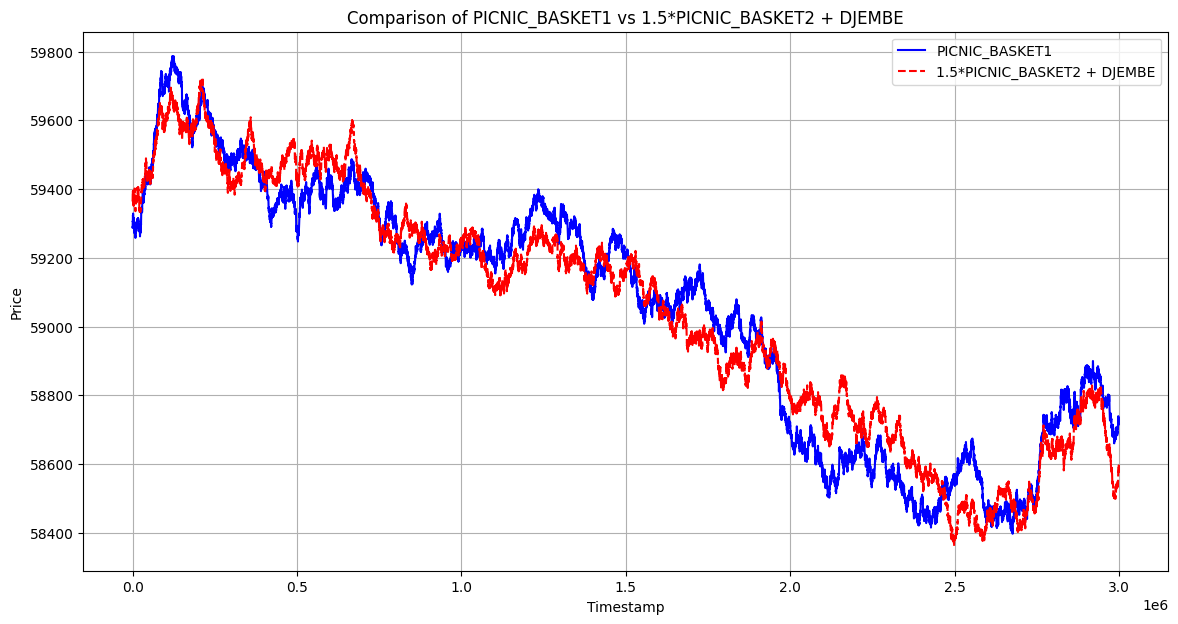

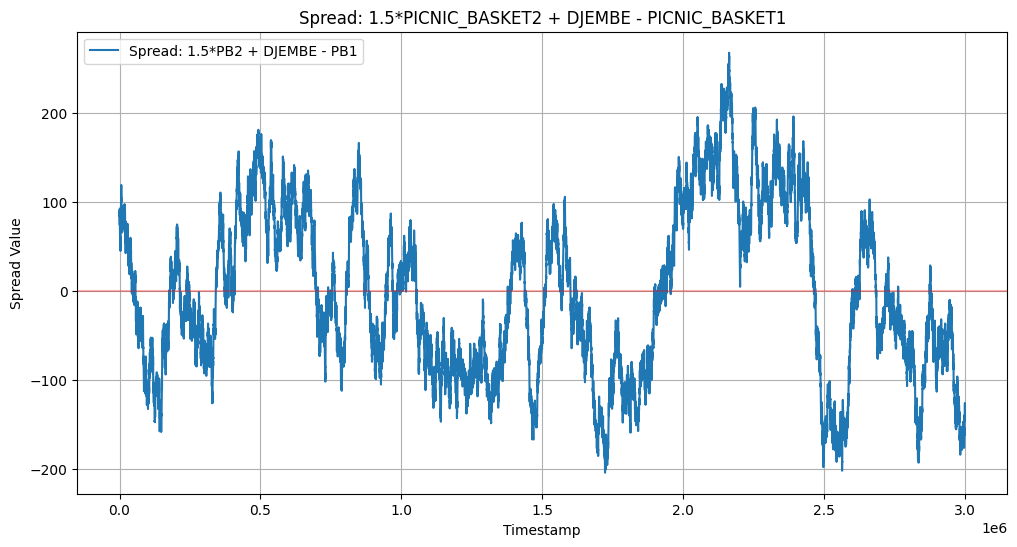

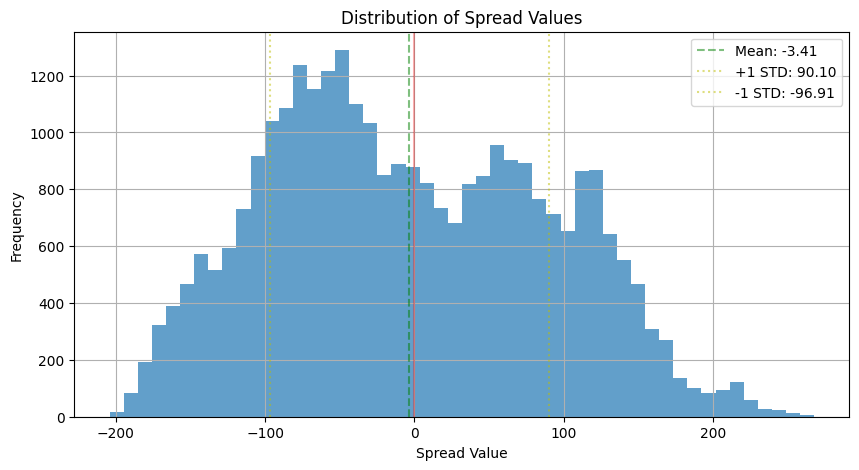


Spread Statistics:
--------------------
Number of observations: 30000
Number of NaN values: 0
Mean: -3.4085
Std Dev: 93.5057
Min: -204.0000
Max: 267.5000
Skewness: 0.2044
Kurtosis: -0.8272


In [23]:
# Plot the baskets and spread over time
if 'spread' in locals() and spread is not None and 'artificial_basket' in locals() and 'reindexed_prices' in locals():
    # Plot the baskets comparison
    plt.figure(figsize=(14, 7))
    plt.plot(reindexed_prices['PICNIC_BASKET1'].index, reindexed_prices['PICNIC_BASKET1'].values, label='PICNIC_BASKET1', color='blue')
    plt.plot(artificial_basket.index, artificial_basket.values, label='1.5*PICNIC_BASKET2 + DJEMBE', color='red', linestyle='--')
    plt.title('Comparison of PICNIC_BASKET1 vs 1.5*PICNIC_BASKET2 + DJEMBE')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot the spread over time
plt.figure(figsize=(12, 6))
plt.plot(spread.index, spread.values, label='Spread: 1.5*PB2 + DJEMBE - PB1')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Spread: 1.5*PICNIC_BASKET2 + DJEMBE - PICNIC_BASKET1')
plt.xlabel('Timestamp')
plt.ylabel('Spread Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot histogram of spread values
plt.figure(figsize=(10, 5))
# Remove NaN values before plotting
spread_clean = spread.dropna()
if len(spread_clean) > 0:
    plt.hist(spread_clean.values, bins=50, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Distribution of Spread Values')
    plt.xlabel('Spread Value')
    plt.ylabel('Frequency')
    
    # Add summary statistics
    mean_spread = spread_clean.mean()
    std_spread = spread_clean.std()
    plt.axvline(x=mean_spread, color='g', linestyle='--', alpha=0.5, 
                label=f'Mean: {mean_spread:.2f}')
    plt.axvline(x=mean_spread + std_spread, color='y', linestyle=':', alpha=0.5,
                label=f'+1 STD: {(mean_spread + std_spread):.2f}')
    plt.axvline(x=mean_spread - std_spread, color='y', linestyle=':', alpha=0.5,
                label=f'-1 STD: {(mean_spread - std_spread):.2f}')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No valid data points to plot', 
             horizontalalignment='center', verticalalignment='center')
plt.grid(True)
plt.show()

# Print summary statistics
print("\nSpread Statistics:")
print("-" * 20)
print(f"Number of observations: {len(spread_clean)}")
print(f"Number of NaN values: {len(spread) - len(spread_clean)}")
print(f"Mean: {spread_clean.mean():.4f}")
print(f"Std Dev: {spread_clean.std():.4f}")
print(f"Min: {spread_clean.min():.4f}")
print(f"Max: {spread_clean.max():.4f}")
print(f"Skewness: {spread_clean.skew():.4f}")
print(f"Kurtosis: {spread_clean.kurtosis():.4f}")

## 6. Apply Kalman Filter to the Spread

Let's apply a Kalman filter to the spread to reduce noise and identify more stable trading opportunities.

Successfully imported pykalman
Successfully applied Kalman filter to the spread


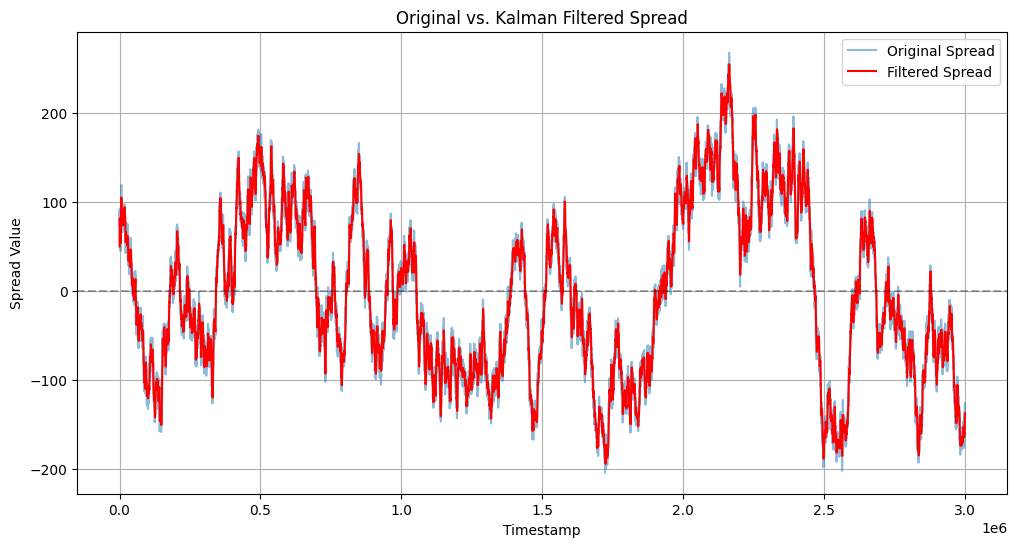


Filtered spread statistics:
Mean: -3.36
Median: -13.06
Min: -193.96
Max: 254.70
Standard deviation: 93.15


In [24]:
# Try to import pykalman, if not available, implement a simple Kalman filter
try:
    from pykalman import KalmanFilter
    print("Successfully imported pykalman")
except ImportError:
    print("Could not import pykalman, using simple Kalman filter implementation")
    
    # Simple Kalman filter implementation
    class SimpleKalmanFilter:
        def __init__(self, process_variance, measurement_variance, initial_value=0):
            self.process_variance = process_variance
            self.measurement_variance = measurement_variance
            self.estimate = initial_value
            self.error_covariance = 1
        
        def filter(self, measurement):
            # Prediction update
            prediction = self.estimate
            prediction_error_covariance = self.error_covariance + self.process_variance
            
            # Measurement update
            kalman_gain = prediction_error_covariance / (prediction_error_covariance + self.measurement_variance)
            filtered_values = []
            
            for m in measurement:
                # Skip NaN values
                if np.isnan(m):
                    filtered_values.append(prediction)
                    continue
                
                self.estimate = prediction + kalman_gain * (m - prediction)
                self.error_covariance = (1 - kalman_gain) * prediction_error_covariance
                
                # Update for next iteration
                prediction = self.estimate
                prediction_error_covariance = self.error_covariance + self.process_variance
                kalman_gain = prediction_error_covariance / (prediction_error_covariance + self.measurement_variance)
                
                filtered_values.append(self.estimate)
            
            return np.array(filtered_values)

# Function to apply Kalman filter to the spread
def apply_kalman_filter_to_spread(spread):
    if spread is None:
        return None
    
    try:
        # Try using pykalman if available
        kf = KalmanFilter(
            initial_state_mean=0,
            initial_state_covariance=1,
            transition_matrices=1,
            observation_matrices=1,
            transition_covariance=0.01,  # Process noise
            observation_covariance=0.5    # Measurement noise
        )
        
        # Filter the spread
        filtered_state_means, _ = kf.filter(spread.values)
        filtered_spread = pd.Series(filtered_state_means.flatten(), index=spread.index)
        
    except NameError:
        # Use the simple Kalman filter implementation
        kf = SimpleKalmanFilter(process_variance=0.01, measurement_variance=1.0)
        filtered_values = kf.filter(spread.values)
        filtered_spread = pd.Series(filtered_values, index=spread.index)
    
    return filtered_spread

# Apply Kalman filter to the spread
if 'spread' in locals() and spread is not None:
    try:
        filtered_spread = apply_kalman_filter_to_spread(spread)
        if filtered_spread is not None:
            print("Successfully applied Kalman filter to the spread")
            
            # Plot the original spread and the filtered spread
            plt.figure(figsize=(12, 6))
            plt.plot(spread.index, spread.values, label='Original Spread', alpha=0.5)
            plt.plot(filtered_spread.index, filtered_spread.values, label='Filtered Spread', color='red')
            plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
            plt.title('Original vs. Kalman Filtered Spread')
            plt.xlabel('Timestamp')
            plt.ylabel('Spread Value')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # Calculate statistics for the filtered spread
            print("\nFiltered spread statistics:")
            print(f"Mean: {filtered_spread.mean():.2f}")
            print(f"Median: {filtered_spread.median():.2f}")
            print(f"Min: {filtered_spread.min():.2f}")
            print(f"Max: {filtered_spread.max():.2f}")
            print(f"Standard deviation: {filtered_spread.std():.2f}")
    except Exception as e:
        print(f"Error applying Kalman filter: {e}")
else:
    print("Cannot apply Kalman filter due to missing spread data")

## 7. Visualize Baskets with Filtered Spread

Let's create a combined visualization of the baskets and the filtered spread.

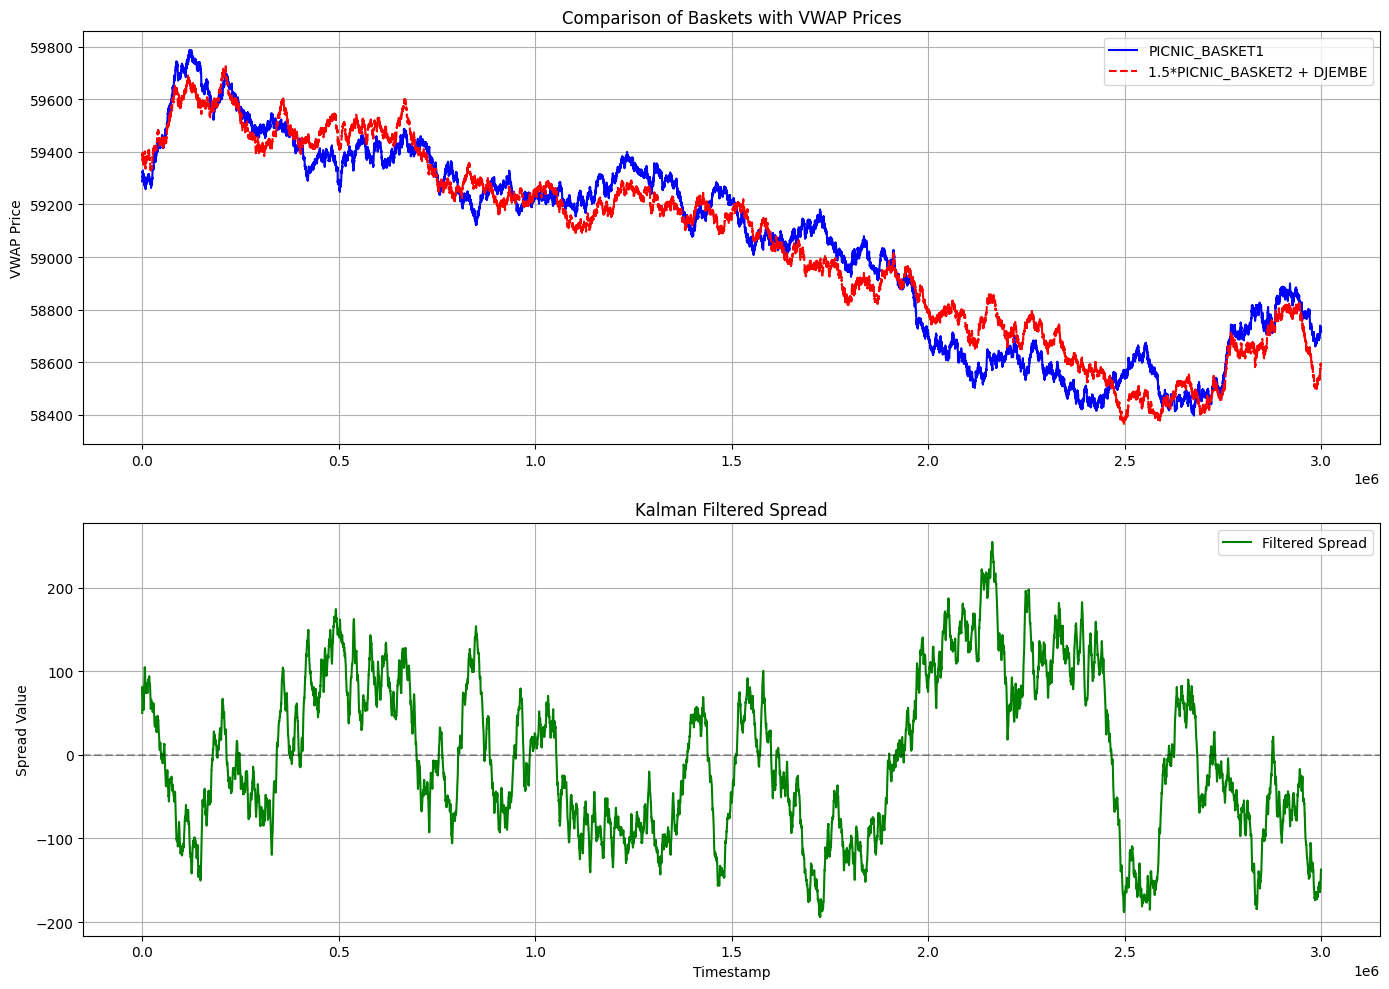

Correlation between PICNIC_BASKET1 and 1.5*PICNIC_BASKET2 + DJEMBE: 0.9664
Percentage of time with positive filtered spread: 45.83%
Percentage of time with negative filtered spread: 54.17%


In [28]:
# Plot the baskets with the filtered spread
if 'filtered_spread' in locals() and filtered_spread is not None and 'artificial_basket' in locals() and 'reindexed_prices' in locals():
    plt.figure(figsize=(14, 10))
    
    # Create a subplot for the baskets
    plt.subplot(2, 1, 1)
    plt.plot(reindexed_prices['PICNIC_BASKET1'].index, reindexed_prices['PICNIC_BASKET1'].values, label='PICNIC_BASKET1', color='blue')
    plt.plot(artificial_basket.index, artificial_basket.values, label='1.5*PICNIC_BASKET2 + DJEMBE', color='red', linestyle='--')
    plt.title('Comparison of Baskets with VWAP Prices')
    plt.ylabel('VWAP Price')
    plt.legend()
    plt.grid(True)
    
    # Create a subplot for the filtered spread
    plt.subplot(2, 1, 2)
    plt.plot(filtered_spread.index, filtered_spread.values, label='Filtered Spread', color='green')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    plt.title('Kalman Filtered Spread')
    plt.xlabel('Timestamp')
    plt.ylabel('Spread Value')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation between baskets and filtered spread
    basket_correlation = reindexed_prices['PICNIC_BASKET1'].corr(artificial_basket)
    print(f"Correlation between PICNIC_BASKET1 and 1.5*PICNIC_BASKET2 + DJEMBE: {basket_correlation:.4f}")
    
    # Calculate percentage of time filtered spread is positive/negative
    positive_filtered = (filtered_spread > 0).mean() * 100
    negative_filtered = (filtered_spread < 0).mean() * 100
    print(f"Percentage of time with positive filtered spread: {positive_filtered:.2f}%")
    print(f"Percentage of time with negative filtered spread: {negative_filtered:.2f}%")
else:
    print("Cannot visualize baskets with filtered spread due to missing data")

## 8. Trading Strategy Considerations

Based on the spread analysis, we can consider potential trading strategies.

Trading signal thresholds (based on standard deviations):
Low threshold: ±93.15
Medium threshold: ±139.73
High threshold: ±186.31

Trading signal statistics:
low_long: 5481 signals (18.27% of time)
low_short: 5639 signals (18.80% of time)
medium_long: 1889 signals (6.30% of time)
medium_short: 1951 signals (6.50% of time)
high_long: 48 signals (0.16% of time)
high_short: 473 signals (1.58% of time)


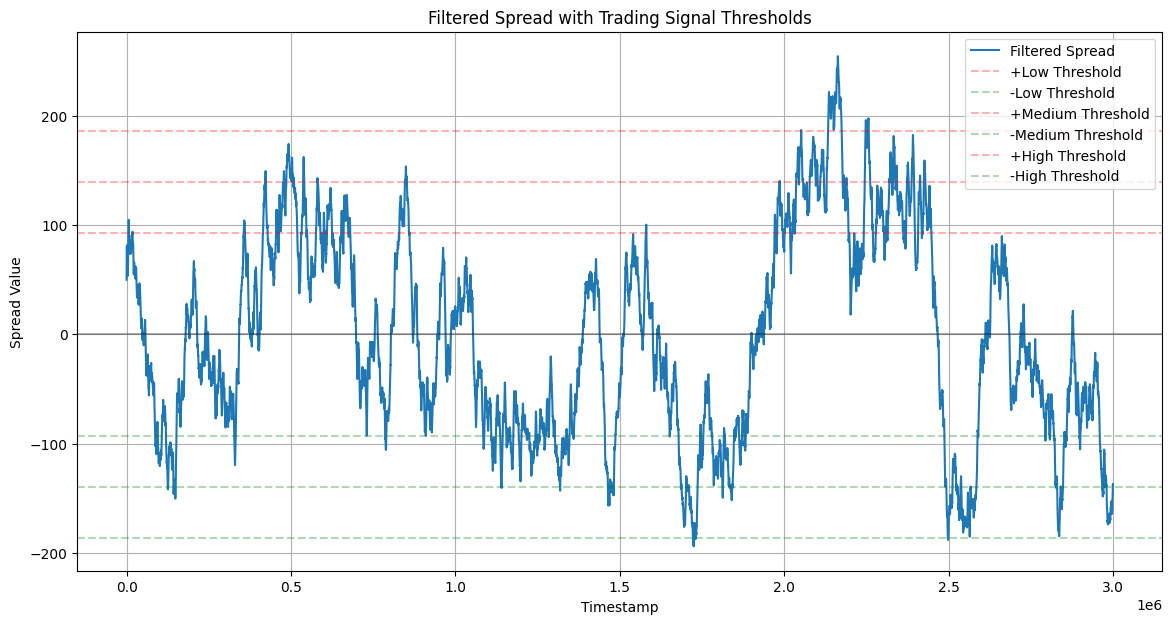

In [29]:
# Define thresholds for trading signals
if 'filtered_spread' in locals() and filtered_spread is not None:
    # Calculate standard deviation of the filtered spread
    spread_std = filtered_spread.std()
    
    # Define thresholds based on standard deviations
    thresholds = {
        'low': 1.0 * spread_std,
        'medium': 1.5 * spread_std,
        'high': 2.0 * spread_std
    }
    
    print("Trading signal thresholds (based on standard deviations):")
    for name, threshold in thresholds.items():
        print(f"{name.capitalize()} threshold: ±{threshold:.2f}")
    
    # Generate trading signals
    signals = pd.DataFrame(index=filtered_spread.index)
    signals['spread'] = filtered_spread
    
    # Generate signals for each threshold
    for name, threshold in thresholds.items():
        # Long signal: spread < -threshold (buy the spread)
        signals[f'{name}_long'] = (filtered_spread < -threshold).astype(int)
        
        # Short signal: spread > threshold (sell the spread)
        signals[f'{name}_short'] = (filtered_spread > threshold).astype(int)
    
    # Count the number of signals
    signal_counts = {}
    for col in signals.columns:
        if col.endswith('_long') or col.endswith('_short'):
            signal_counts[col] = signals[col].sum()
    
    # Calculate the percentage of signals
    total_points = len(signals)
    signal_percentages = {k: v / total_points * 100 for k, v in signal_counts.items()}
    
    # Display the counts and percentages
    print("\nTrading signal statistics:")
    for name in signal_counts.keys():
        print(f"{name}: {signal_counts[name]} signals ({signal_percentages[name]:.2f}% of time)")
    
    # Plot the filtered spread with trading signals
    plt.figure(figsize=(14, 7))
    plt.plot(filtered_spread.index, filtered_spread.values, label='Filtered Spread')
    
    # Add threshold lines
    for name, threshold in thresholds.items():
        plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.3, label=f'+{name.capitalize()} Threshold')
        plt.axhline(y=-threshold, color='g', linestyle='--', alpha=0.3, label=f'-{name.capitalize()} Threshold')
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Filtered Spread with Trading Signal Thresholds')
    plt.xlabel('Timestamp')
    plt.ylabel('Spread Value')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Cannot generate trading signals due to missing filtered spread data")

C:\Users\fujos\AppData\Local\Temp\ipykernel_65752\945986981.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  strategy['position'] = strategy['position'].replace(0, np.nan).fillna(method='ffill').fillna(0)


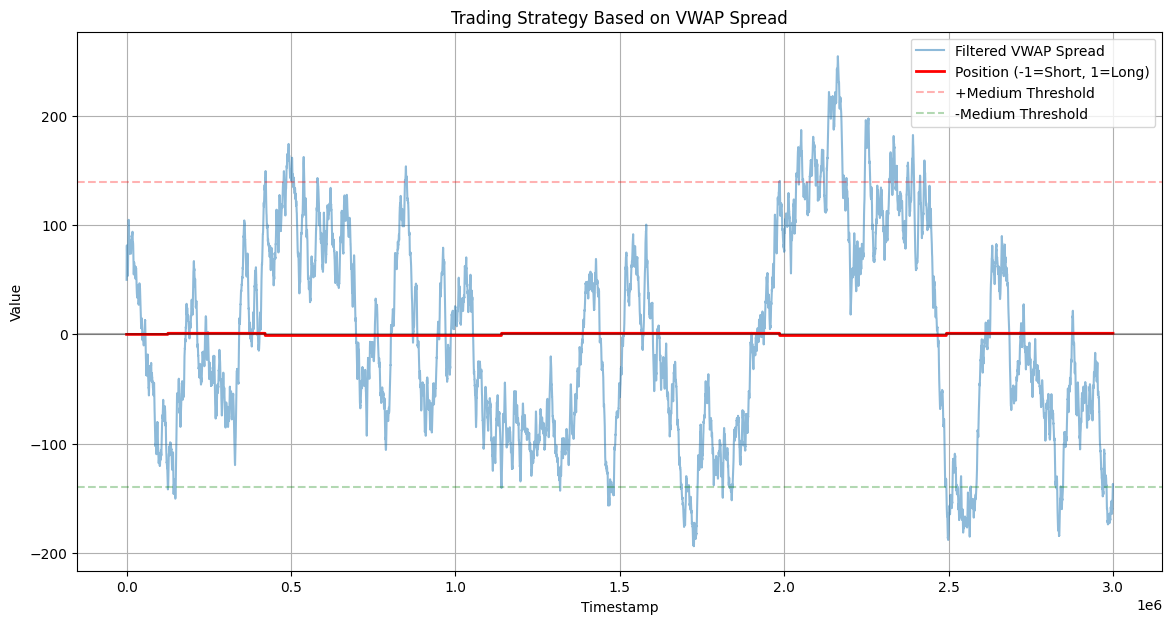


Strategy Summary:
Long positions: 16488 (54.96% of time)
Short positions: 12259 (40.86% of time)
Neutral positions: 1253 (4.18% of time)


: 

In [ ]:
# Create a sample trading strategy simulation based on VWAP spread
if 'filtered_spread' in locals() and filtered_spread is not None and 'artificial_basket' in locals() and 'reindexed_prices' in locals():
    # Use medium threshold for this example
    if 'thresholds' in locals() and 'medium' in thresholds:
        threshold = thresholds['medium']
    else:
        # Calculate standard deviation of the filtered spread if thresholds not defined
        spread_std = filtered_spread.std()
        threshold = 1.5 * spread_std  # Medium threshold
        print(f"Using calculated medium threshold: ±{threshold:.2f}")
    
    # Create a DataFrame for the strategy
    strategy = pd.DataFrame(index=filtered_spread.index)
    strategy['spread'] = filtered_spread
    strategy['position'] = 0  # Initialize position to 0 (no position)
    
    # Set positions based on threshold crossings
    strategy.loc[filtered_spread > threshold, 'position'] = -1  # Short the spread
    strategy.loc[filtered_spread < -threshold, 'position'] = 1   # Long the spread
    
    # Forward fill positions (maintain position until a new signal)
    strategy['position'] = strategy['position'].replace(0, np.nan).fillna(method='ffill').fillna(0)
    
    # Plot the positions
    plt.figure(figsize=(14, 7))
    plt.plot(filtered_spread.index, filtered_spread.values, label='Filtered VWAP Spread', alpha=0.5)
    plt.plot(strategy.index, strategy['position'], label='Position (-1=Short, 1=Long)', color='red', linewidth=2)
    plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.3, label=f'+Medium Threshold')
    plt.axhline(y=-threshold, color='g', linestyle='--', alpha=0.3, label=f'-Medium Threshold')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Trading Strategy Based on VWAP Spread')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print strategy summary
    long_count = (strategy['position'] == 1).sum()
    short_count = (strategy['position'] == -1).sum()
    neutral_count = (strategy['position'] == 0).sum()
    total_count = len(strategy)
    
    print("\nStrategy Summary:")
    print(f"Long positions: {long_count} ({long_count/total_count*100:.2f}% of time)")
    print(f"Short positions: {short_count} ({short_count/total_count*100:.2f}% of time)")
    print(f"Neutral positions: {neutral_count} ({neutral_count/total_count*100:.2f}% of time)")
else:
    print("Cannot create trading strategy simulation due to missing data")

## 9. Conclusion

In this notebook, we analyzed the spread between 1.5*PICNIC_BASKET2 + DJEMBE and PICNIC_BASKET1 using VWAP prices. Here's a summary of our findings:

1. We calculated the spread between 1.5*PICNIC_BASKET2 + DJEMBE and PICNIC_BASKET1 using VWAP prices.
2. We visualized both the baskets and the spread over time, comparing the actual PICNIC_BASKET1 with our artificial basket (1.5*PICNIC_BASKET2 + DJEMBE).
3. We applied a Kalman filter to reduce noise in the spread.
4. We identified potential trading opportunities based on the filtered VWAP spread.

### Potential Trading Strategy

A potential trading strategy based on this VWAP spread analysis could be:

- When the filtered VWAP spread is significantly positive (above threshold): Sell the spread
  - Sell 1.5 units of PICNIC_BASKET2
  - Sell 1 unit of DJEMBE
  - Buy 1 unit of PICNIC_BASKET1

- When the filtered VWAP spread is significantly negative (below threshold): Buy the spread
  - Buy 1.5 units of PICNIC_BASKET2
  - Buy 1 unit of DJEMBE
  - Sell 1 unit of PICNIC_BASKET1

The strategy assumes that the spread will revert to its mean over time, allowing for profitable trades when the spread deviates significantly from its historical average. Using VWAP prices instead of mid prices provides a more accurate representation of the actual trading prices, potentially leading to more reliable signals.

### Next Steps

To further develop this strategy, we could:

1. Backtest the strategy with historical data to evaluate its performance.
2. Optimize the threshold parameters to maximize returns.
3. Implement risk management rules to limit potential losses.
4. Consider transaction costs and slippage in the strategy evaluation.
5. Explore alternative filtering methods to improve signal quality.
6. Compare the performance of VWAP-based spreads versus mid-price-based spreads.
7. Analyze the impact of different time windows for VWAP calculation on the spread behavior.